Multi-language embedding

https://github.com/facebookresearch/MUSE

In [67]:
from collections import defaultdict
import itertools as it
import gensim
from Levenshtein import distance
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.spatial.distance import cosine
from scipy.stats import ttest_rel

import tqdm

In [14]:
model_fp = "/Users/benpeloquin/Data/nlp/google-wv/GoogleNews-vectors-negative300.bin"
model = gensim.models.KeyedVectors.load_word2vec_format(model_fp, binary=True)  

In [15]:
model.vectors.shape

(3000000, 300)

In [4]:
vocab = model.vocab
vocab_words = [word for i, word in enumerate(vocab.keys()) if i in idxs] 

In [54]:
def get_vocab_sample(model, n=500):
    vocab_words_1 = list(model.vocab.keys())
    vocab_words_2 = list(model.vocab.keys())
    idxs = np.random.choice(range(len(vocab_words_1)), n)
    vocab_words = [word for i, word in enumerate(vocab_words_1) if i in idxs]
    vocab_words_random = [word for i, word in enumerate(vocab_words_2) if i in idxs]
    np.random.shuffle(vocab_words_random)
    vocab_vals = model.vectors[idxs, :]
    # Basic check on randomization
    assert vocab_words[0] != vocab_words_random[0]
    return vocab_vals, vocab_words, vocab_words_random

def get_pairwise_distances(items, dist_fn=lambda x: x):
    pairs = list(it.product(items, items))
    final_pairs = []
    dists = []
    for a, b in pairs:
        dist = dist_fn(a, b)
        # Note (BP): You may need to complicate this...
        if dist == 0:
            continue
        dists.append(dist)
        final_pairs.append((a, b))
    return dists, final_pairs

def get_distance_correlations(model, n=500):
    vals, words, random_words = get_vocab_sample(model, n)
    val_dists, _ = get_pairwise_distances(vals, cosine)
    word_dists, _ = get_pairwise_distances(words, distance)
    random_word_dists, _ = get_pairwise_distances(random_words, distance)
    return np.corrcoef(val_dists, word_dists)[0][1], np.corrcoef(val_dists, random_word_dists)[0][1]

In [58]:
def run_distance_correlations(model, n_sims=100, n_sample=100):
    real_corrs = []
    random_corrs = []
    for sim in tqdm.tqdm(range(n_sims)):
        real_corr, random_corr = get_distance_correlations(model, n_sample)
        real_corrs.append(real_corr)
        random_corrs.append(random_corr)
    return real_corrs, random_corrs    

In [65]:
real_corrs, random_corrs = run_distance_correlations(model, 50, 100)

100%|██████████| 50/50 [12:33<00:00, 15.07s/it]


Text(0.5, 0, 'Corr')

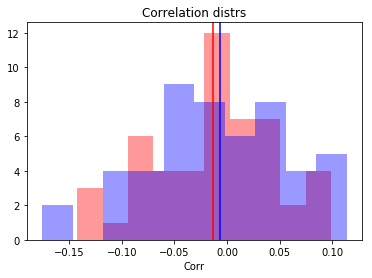

In [71]:
plt.title("Correlation distrs")
plt.hist(real_corrs, color="red", alpha=0.4)
plt.hist(random_corrs, color="blue", alpha=0.4)
plt.axvline(np.mean(real_corrs), color="red")
plt.axvline(np.mean(random_corrs), color="blue")
plt.xlabel("Corr")

In [67]:
from scipy.stats import ttest_ind
ttest_ind(real_corrs, random_corrs)

Ttest_indResult(statistic=-0.522774726118779, pvalue=0.602310931317155)

In [2]:
from urllib.request import urlopen

test_url = "https://dl.fbaipublicfiles.com/arrival/vectors/wiki.multi.en.vec"

f = urlopen(test_url)
data = {}
header = f.readline()
header_data = header.split()
vocab_size, hidden_size = int(header_data[0]), int(header_data[1])
pbar = tqdm.tqdm(total=vocab_size)
for line_idx, line in tqdm.tqdm(enumerate(f.readlines())):
    elements = line.split()
    word = elements[0]
    vec = np.array(list(map(float, elements[1:])))
    data[word] = vec
    pbar.update()
pbar.close()

 93%|█████████▎| 185012/200000 [01:26<00:01, 13535.34it/s]
185013it [00:13, 13827.86it/s]
 97%|█████████▋| 193576/200000 [01:26<00:00, 13691.40it/s]
193576it [00:14, 13826.52it/s]
100%|██████████| 200000/200000 [01:27<00:00, 2283.67it/s] 


In [10]:
def get_vocab_sample(model, n=500):
    """

    Parameters
    ----------
    model: dict
        Keys are words, values are vector repr.
    n: int [Default: 500]
        Number of words to sample.

    Returns
    -------
    tuple (np.array, np.array, np.array)
        Vector, words, random ordered words.

    """
    vocab_words_1 = np.array(list(model.keys()))
    vocab_words_2 = np.array(list(model.keys()))
    vector_repr = np.array(list(model.values()))

    idxs = np.random.choice(range(len(vocab_words_1)), n)
    words_sample = vocab_words_1[idxs]
    words_sample_random = vocab_words_2[idxs]
    vector_sample = vector_repr[idxs, :]
    np.random.shuffle(words_sample_random)
    # Basic check on randomization
    assert words_sample[0] != words_sample_random[0]
    return vector_sample, words_sample, words_sample_random


def get_pairwise_distances(items, dist_fn=lambda x: x):
    pairs = list(it.product(items, items))
    final_pairs = []
    dists = []
    
    for a, b in pairs:
        dist = dist_fn(a, b)
        # Note (BP): You may need to complicate this...
        if dist == 0:
            continue
        dists.append(dist)
        final_pairs.append((a, b))
    return dists, final_pairs

In [11]:
v, w1, w2 = get_vocab_sample(data, 10)

In [23]:
# get_pairwise_distances(v, cosine)

# Read samples trained elsewhere

In [24]:
local_dir = "/Users/benpeloquin/Data/projects/arbitrary_signs/outputs-2-20190530/"

In [27]:
def fp_creator_correlations(dir_path, language, typ):
    return os.path.join(dir_path, "{}_{}_correlations.npy".format(language, typ))
    
def fp_creator_model(dir_path, language, typ):
    return os.path.join(dir_path, "{}_model.pickle".format(language, typ))

In [79]:
languages = ["en", "es", "fr"]
typs = ["random", "real"]
models = defaultdict(dict)
for lang, typ in it.product(languages, typs):
    curr_fp = fp_creator_correlations(local_dir, lang, typ)
    models[lang][typ] = np.load(curr_fp)

In [80]:
ttest_rel(models["en"]["random"], models["en"]["real"])

Ttest_relResult(statistic=6.487972770389009, pvalue=3.6022055465400556e-10)

en:	(-6.488, 3.6022055465e-10)
es:	(16.354, 0.0)
fr:	(32.03, 0.0)


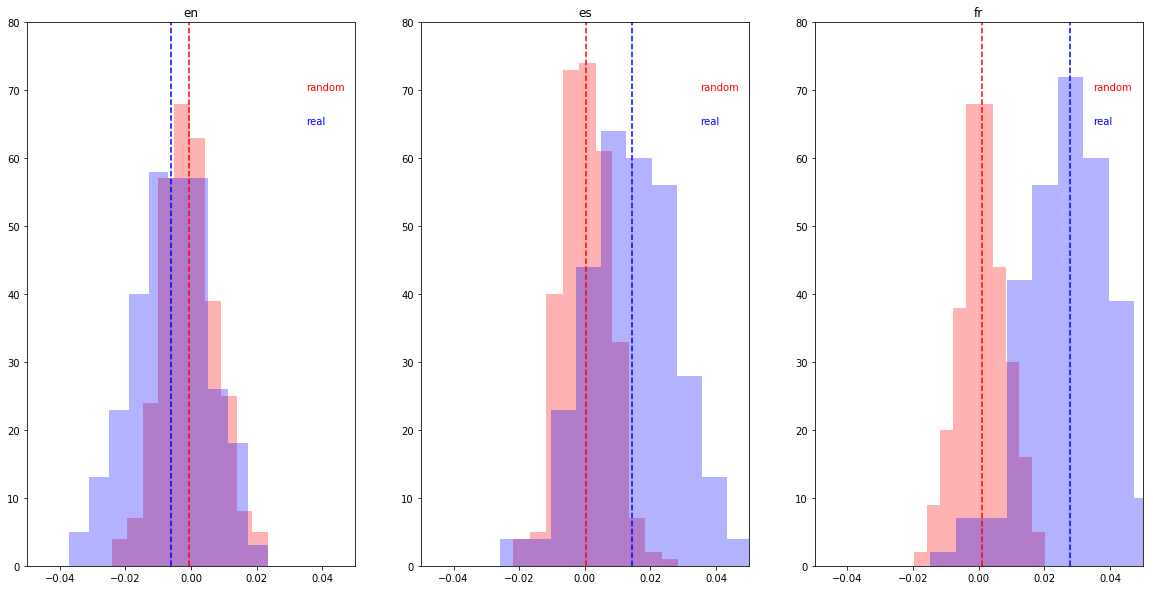

In [91]:
plt.figure(figsize=(20, 10))
plot_data = {
    "n_rows": 1,
    "n_cols": 3
}
# print("""
#     Red: random\n
#     Blue: real
#     """)
d_t_tests = {}
for subplot_num, lang in enumerate(languages, 1):
    real = models[lang]["real"]
    rand = models[lang]["random"]
    plt.subplot(plot_data["n_rows"], plot_data["n_cols"], subplot_num)    
    
    plt.title("{}".format(lang))
    
    # Random
    plt.hist(rand, alpha=0.3, color="red")
    plt.axvline(np.mean(rand), color="red", linestyle='dashed')
    
    # Real
    plt.hist(real, alpha=0.3, color="blue")
    plt.axvline(np.mean(real), color="blue", linestyle='dashed')
    
    # Legend
    plt.text(0.035, 70, "random", color="red")
    plt.text(0.035, 65, "real", color="blue")
    
    # Settings
    plt.xlim(-0.05, 0.05)
    plt.ylim(0, 80)
    
    # ttest
    d_t_tests[lang] = ttest_rel(real, rand)
print("en:\t{}\nes:\t{}\nfr:\t{}".format(*map(lambda x: (round(d_t_tests[x][0], 3), 
                                                               round(d_t_tests[x][1], 20)), languages)))